In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

-----

# EDA for babynames

## Load Data

In [3]:
raw_national = pd.read_csv("../data/StateNames.csv")
raw_national.shape

(5647426, 6)

In [4]:
# more than 5M rows, let's choose a sample
raw_nat_sample = raw_national.sample(n=100000)
raw_nat_sample.shape

(100000, 6)

### Pythonize Column Names

In [5]:
# take a look
raw_nat_sample.columns = map(lambda x : x.lower().replace(' ','_').replace('count','frequency'),raw_nat_sample.columns)
raw_nat_sample.head(10)

,id,name,year,gender,state,frequency
2540655,2540656,Kassandra,1998,F,MI,21
659557,659558,Missael,1996,M,CA,15
4079333,4079334,Lynn,1967,F,OK,33
2337595,2337596,Sophia,1967,F,MD,9
3255388,3255389,Chelsea,1988,F,NE,90
1119563,1119564,Keegan,1990,M,FL,12
3514733,3514734,Adelaide,2014,F,NM,7
3994438,3994439,Arthur,1952,M,OH,267
152038,152039,Jonah,2013,M,AL,42
1374446,1374447,Bradley,2000,M,HI,8


### Task 1: find out classical names

Classical name is names with longest historical data. Because if a name appears in each every year, it means it's popular.

In [6]:
raw_nat_sample.sort_values(by=['name','year','state','frequency'],ascending=True).head()

,id,name,year,gender,state,frequency
5061278,5061279,Aadan,2008,M,TX,5
1724525,1724526,Aaden,2007,M,IL,8
349401,349402,Aaden,2008,M,AZ,20
5061859,5061860,Aaden,2009,M,TX,140
805943,805944,Aaden,2010,M,CO,9


In [7]:
# prepare unique (name, year, count) and aggregate different state, drop column['id']

from IPython.display import display

name_year_count = raw_nat_sample.drop(['id'],axis=1).groupby(['name','gender','year']).sum()
print(name_year_count.shape)
name_year_count.head()

(80086, 1)


frequency
name  gender year           
Aadan M      2008          5
Aaden M      2007          8
             2008         20
             2009        140
             2010         27

In [8]:
# reset index to transform multi-index into columns
name_year_count.reset_index(inplace=True)
print(name_year_count.shape)
name_year_count.head()

(80086, 4)


,name,gender,year,frequency
0,Aadan,M,2008,5
1,Aaden,M,2007,8
2,Aaden,M,2008,20
3,Aaden,M,2009,140
4,Aaden,M,2010,27


In [9]:
# crosstab name and year
year_name_crosstab = pd.crosstab(index=name_year_count.year, \
                                 columns=[name_year_count.name,name_year_count.gender],\
                                 values=name_year_count.frequency,\
                                 aggfunc=np.sum)
year_name_crosstab.head()

name   Aadan Aaden Aadi Aahil Aaiden Aaleyah Aaliah Aaliya Aaliyah Aaliyha  \
gender     M     M    M     M      M       F      F      F       F       F   
year                                                                         
1910     NaN   NaN  NaN   NaN    NaN     NaN    NaN    NaN     NaN     NaN   
1911     NaN   NaN  NaN   NaN    NaN     NaN    NaN    NaN     NaN     NaN   
1912     NaN   NaN  NaN   NaN    NaN     NaN    NaN    NaN     NaN     NaN   
1913     NaN   NaN  NaN   NaN    NaN     NaN    NaN    NaN     NaN     NaN   
1914     NaN   NaN  NaN   NaN    NaN     NaN    NaN    NaN     NaN     NaN   

name   ... Zury Zvi Zyaire     Zyion Zykiria Zyler Zymere Zyon      
gender ...    F   M      F   M     M       F     M      M    F   M  
year   ...                                                          
1910   ...  NaN NaN    NaN NaN   NaN     NaN   NaN    NaN  NaN NaN  
1911   ...  NaN NaN    NaN NaN   NaN     NaN   NaN    NaN  NaN NaN  
1912   ...  NaN NaN    NaN NaN   NaN     NaN   NaN    NaN  NaN NaN  
1913   ...  NaN NaN    NaN NaN   NaN     NaN   NaN    NaN  NaN NaN  
1914   ...  NaN NaN    NaN NaN   NaN     NaN   NaN    NaN  NaN NaN  

[5 rows x 11051 columns]

In [10]:
# find names with most long history data
def get_classical_name_billboard(since=1910):
    return year_name_crosstab.ix[since:,:].count(axis=0).sort_values(ascending=False)

#t = get_classical_name_billboard()
#print(t.ix[(t.index.get_level_values('Rachel',level='name')) & (t.index.get_level_values('F',level='gender'))])
#print(t.loc['Rachel','F'])

print(get_classical_name_billboard().head())
def find_classical_rank(name,gender,since=1910):
    '''
    name, e.g.'John'
    gender, e.g. 'M' or 'F'
    
    return: rank in classical name billboard
    '''
    #print(names_with_long_history_sorted.head())
    billboard = get_classical_name_billboard(since).reset_index()
    return billboard[(billboard.name==name) & (billboard.gender==gender)].index[0]+1


find_classical_rank('Rachel','F',since=2000)

name     gender
Charles  M         73
Larry    M         69
Anna     F         69
Kenneth  M         68
Mary     F         67
dtype: int64


1092

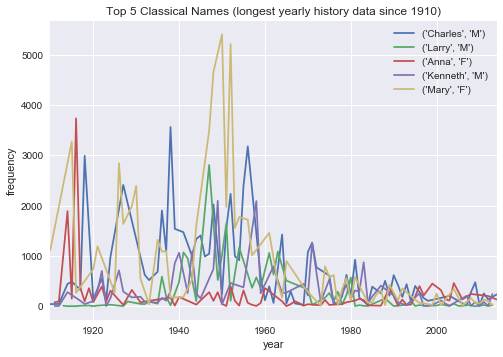

In [11]:
# print the most popular classical name (name with longest yearly history data)

N = 5
since=1910

classical_billboard = get_classical_name_billboard(since=since)

for i in range(N):
    # we need this evil for loop, otherwise dropna() is dropping the whole column
    year_name_crosstab[classical_billboard.index[i]].dropna().plot(kind='line');
plt.legend(classical_billboard.index[:N])
plt.title(f"Top {N} Classical Names (longest yearly history data since {since})");
plt.xlabel("year");
plt.ylabel("frequency");

### Taks 2: find out popular names

Popular names is purely depends on frequency of past occurance, since a particular year, regardless of "how many years of historical data".

In [12]:
def get_popular_name_billboard(since=1910):
    '''
    since: begining of year
    
    return: list of [name, gender, avg_year_frequency]
    '''
    return year_name_crosstab.loc[since:].mean(axis=0,skipna=True).sort_values(ascending=False)

get_popular_name_billboard().head()

name     gender
Robert   M         1760.545455
James    M         1357.689655
John     M         1217.793651
David    M         1213.790323
Michael  M         1029.377049
dtype: float64

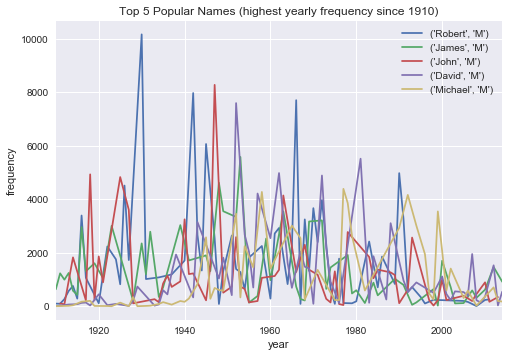

In [13]:
# print the most popular name (name with highest avg yearly frequency across history data)

N = 5
since=1910

popular_name_billboard = get_popular_name_billboard(since=since)

for i in range(N):
    # we need this evil for loop, otherwise dropna() is dropping the whole column
    year_name_crosstab[popular_name_billboard.index[i]].dropna().plot(kind='line');
plt.legend(popular_name_billboard.index[:N])
plt.title(f"Top {N} Popular Names (highest yearly frequency since {since})");
plt.xlabel("year");
plt.ylabel("frequency");

### Task 3: find out frequency trend by given (name, gender)

Find out what is the yearly frequency trend by given (name, gender)

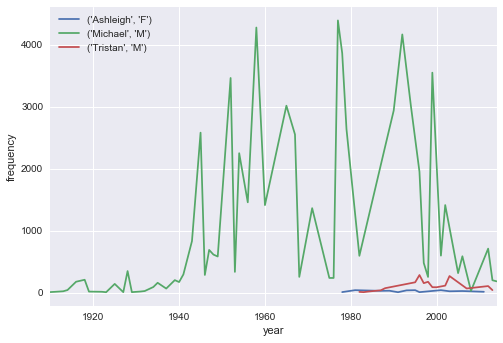

In [18]:
def print_name_trend(names,since=1910):
    """ Given a list of names, plot name yearly frequency trend"""
    plt.figure()
    plt.xlabel("year")
    plt.ylabel("frequency")
    for name in names:
        year_name_crosstab.loc[since:][name].dropna().plot(kind='line');
    plt.legend(names)

print_name_trend([('Ashleigh','F'),('Michael','M'),('Tristan','M')],since=1910)

### Task 4: calculate popularity of names

Add column popularity by following definition:

$ popularity = \frac{frequency of (gender, name ,year)}{frequency of (gender,year)} $

In [ ]:
#TODO

### Task 5: which name has the largest sudden popularity gain v.s. N years avg before

In [15]:
name_year_count = raw_nat_sample.drop(['id'],axis=1).groupby(['name','gender','year']).sum()
print(name_year_count.shape)
name_year_count.head()

(80086, 1)


frequency
name  gender year           
Aadan M      2008          5
Aaden M      2007          8
             2008         20
             2009        140
             2010         27

('Robert', 'M', 1930)
('Robert', 'M', 1931)


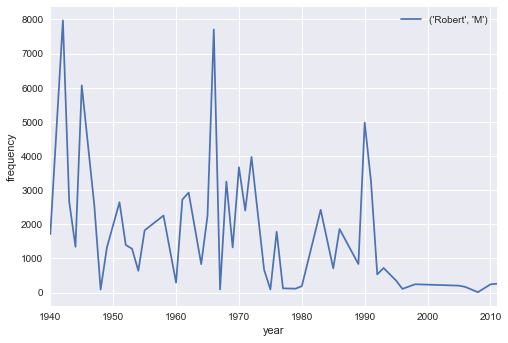

In [16]:
xtab = year_name_crosstab.copy()
xtab.fillna(0,inplace=True)
print(np.argmax(xtab.unstack().diff()))
print(np.argmin(xtab.unstack().diff()))
print_name_trend([('Robert','M')],since=1940)

In [13]:
raw_nat_sample['popularity'] = raw_nat_sample.frequency.values*1000000/raw_nat_sample.groupby(['year','gender'])['frequency'].transform(sum).values

In [14]:
raw_nat_sample.groupby(['year','gender']).sum()

id  frequency  popularity
year gender                                   
1910 F        538802145       5978   1000000.0
     M        374388660       3010   1000000.0
1911 F        507784900       5356   1000000.0
     M        356896367       3944   1000000.0
1912 F        661501320      10261   1000000.0
     M        539153366       6096   1000000.0
1913 F        732471880       9942   1000000.0
     M        581042532       8681   1000000.0
1914 F        852565539      11192   1000000.0
     M        758098943      11750   1000000.0
1915 F        882329791      16618   1000000.0
     M        874681154      14136   1000000.0
1916 F        937497161      15673   1000000.0
     M        936583377      14971   1000000.0
1917 F        911460987      15545   1000000.0
     M        922899891      18376   1000000.0
1918 F       1091755359      20472   1000000.0
     M        912280968      15881   1000000.0
1919 F        994467711      15651   1000000.0
     M        887067591      11920   1000000.0
1920 F        980351012      17951   1000000.0
     M        867924796      19916   1000000.0
1921 F       1159290107      21929   1000000.0
     M       1030135588      17770   1000000.0
1922 F       1025897110      23986   1000000.0
     M        840732012      22698   1000000.0
1923 F       1068230378      21057   1000000.0
     M        874633113      13652   1000000.0
1924 F       1071285487      21327   1000000.0
     M        870435388      22856   1000000.0
...                 ...        ...         ...
2000 F       2148440797      24780   1000000.0
     M       1758662295      30431   1000000.0
2001 F       2283170585      33073   1000000.0
     M       1871724741      29184   1000000.0
2002 F       2216768644      27935   1000000.0
     M       1693614350      32021   1000000.0
2003 F       2414162968      27608   1000000.0
     M       1789268137      34644   1000000.0
2004 F       2219216063      27397   1000000.0
     M       1993795972      34358   1000000.0
2005 F       2518941608      25326   1000000.0
     M       2165194131      32882   1000000.0
2006 F       2381422636      27131   1000000.0
     M       2107036678      33265   1000000.0
2007 F       2495044262      24883   1000000.0
     M       2025236609      31660   1000000.0
2008 F       2600761355      26081   1000000.0
     M       2255530728      38168   1000000.0
2009 F       2512758702      25630   1000000.0
     M       2241191667      36501   1000000.0
2010 F       2432528485      24566   1000000.0
     M       2223574481      32313   1000000.0
2011 F       2529183251      21777   1000000.0
     M       2225147401      32783   1000000.0
2012 F       2519453421      25475   1000000.0
     M       2253429986      32544   1000000.0
2013 F       2426103597      23682   1000000.0
     M       2251555027      27693   1000000.0
2014 F       2457189347      23762   1000000.0
     M       2278887978      30598   1000000.0

[210 rows x 3 columns]